In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:

# don't do this, it's too big! see separate notebook chartevents_processors.ipynb
# df_chartevents = pd.read_csv(mimic_root + 'CHARTEVENTS.csv')

In [4]:
import pandas as pd

def load_icd9_mapping(filepath: str) -> pd.DataFrame:
    """
    Load and clean the ICD-9-CM full description file, properly creating 3-digit 'recode' values.

    Args:
        filepath (str): Path to the ICD-9 Excel file.

    Returns:
        pd.DataFrame: Clean mapping with ['recode', 'description'] where recode is integer.
    """
    # Load file
    icd9_df = pd.read_excel(filepath, dtype=str)

    # Standardize column names
    icd9_df.columns = icd9_df.columns.str.strip().str.upper()
    icd9_df.rename(columns={'DIAGNOSIS CODE': 'code', 'LONG DESCRIPTION': 'description'}, inplace=True)

    # Remove codes with letters (E and V codes)
    icd9_df = icd9_df[~icd9_df['code'].str.contains('[a-zA-Z]', na=False)]

    # Remove periods but do NOT strip leading zeros yet
    icd9_df['code'] = icd9_df['code'].str.replace('.', '', regex=False)

    # --- Important: slice first three characters *before* stripping leading zeros
    icd9_df['recode'] = icd9_df['code'].str.slice(0, 3)

    # Now safely strip leading zeros from 3-digit recode
    icd9_df['recode'] = icd9_df['recode'].str.lstrip('0')

    # Drop any empty recode values
    icd9_df = icd9_df[icd9_df['recode'] != '']

    # Convert recode to int
    icd9_df['recode'] = icd9_df['recode'].astype(int)

    # Drop duplicates: keep the first description per recode
    icd9_mapping = icd9_df[['recode', 'description']].drop_duplicates(subset='recode').copy()

    # Reset index
    icd9_mapping = icd9_mapping.reset_index(drop=True)

    return icd9_mapping


In [5]:
# clean up patients table by age
df_patients = pd.read_csv('PATIENTS.csv')

# Calculate age function
def calculate_age(dob, dod):
    if isinstance(dod, float):
        # this means it is nan, i.e. patient is ALIVE!
        dod_date = datetime.now() + relativedelta(years=100)
    else:
        dod_date = datetime.strptime(dod, "%Y-%m-%d %H:%M:%S")

    dob_date = datetime.strptime(dob, "%Y-%m-%d %H:%M:%S")

    age = (dod_date - dob_date).days // 365
    return age

# Apply calculate_age function to create "age" column
df_patients["age"] = df_patients.apply(lambda row: calculate_age(row["DOB"], row["DOD"]), axis=1)

# Filter out rows with age greater than or equal to 100
df_patients = df_patients[(df_patients["age"] > 0) & (df_patients["age"] < 100)]
df_patients.dropna(subset=['age'])
# # Display the updated DataFrame
df_patients.head()
df_patients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33864 entries, 0 to 46519
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       33864 non-null  int64 
 1   SUBJECT_ID   33864 non-null  int64 
 2   GENDER       33864 non-null  object
 3   DOB          33864 non-null  object
 4   DOD          14214 non-null  object
 5   DOD_HOSP     9017 non-null   object
 6   DOD_SSN      12115 non-null  object
 7   EXPIRE_FLAG  33864 non-null  int64 
 8   age          33864 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 2.6+ MB


In [6]:
# clean up some things in admissions table, based on our lecture code for LOS
df_admissions = pd.read_csv('ADMISSIONS.csv')

# Convert admission and discharge times to datatime type
df_admissions['ADMITTIME'] = pd.to_datetime(df_admissions['ADMITTIME'])
df_admissions['DISCHTIME'] = pd.to_datetime(df_admissions['DISCHTIME'])

# Convert timedelta type into float 'days', 86400 seconds in a day
df_admissions['LOS'] = (df_admissions['DISCHTIME'] - df_admissions['ADMITTIME']).dt.total_seconds()/86400

# Drop LOS < 0
df_admissions = df_admissions[df_admissions['LOS'] > 0]

# Pre-emptively drop some columns that I don't need anymore
df_admissions.drop(columns=['DISCHTIME', 'ROW_ID',
                'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG',
                'HAS_CHARTEVENTS_DATA'], inplace=True)

# Mark admissions where patients died in boolean column
df_admissions['DECEASED'] = df_admissions['DEATHTIME'].notnull().map({True:1, False:0})
df_admissions.head()
df_admissions.info()


<class 'pandas.core.frame.DataFrame'>
Index: 58878 entries, 0 to 58975
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SUBJECT_ID          58878 non-null  int64         
 1   HADM_ID             58878 non-null  int64         
 2   ADMITTIME           58878 non-null  datetime64[ns]
 3   DEATHTIME           5774 non-null   object        
 4   ADMISSION_TYPE      58878 non-null  object        
 5   ADMISSION_LOCATION  58878 non-null  object        
 6   DISCHARGE_LOCATION  58878 non-null  object        
 7   INSURANCE           58878 non-null  object        
 8   LANGUAGE            33606 non-null  object        
 9   RELIGION            58426 non-null  object        
 10  MARITAL_STATUS      48781 non-null  object        
 11  ETHNICITY           58878 non-null  object        
 12  DIAGNOSIS           58853 non-null  object        
 13  LOS                 58878 non-null  float64       


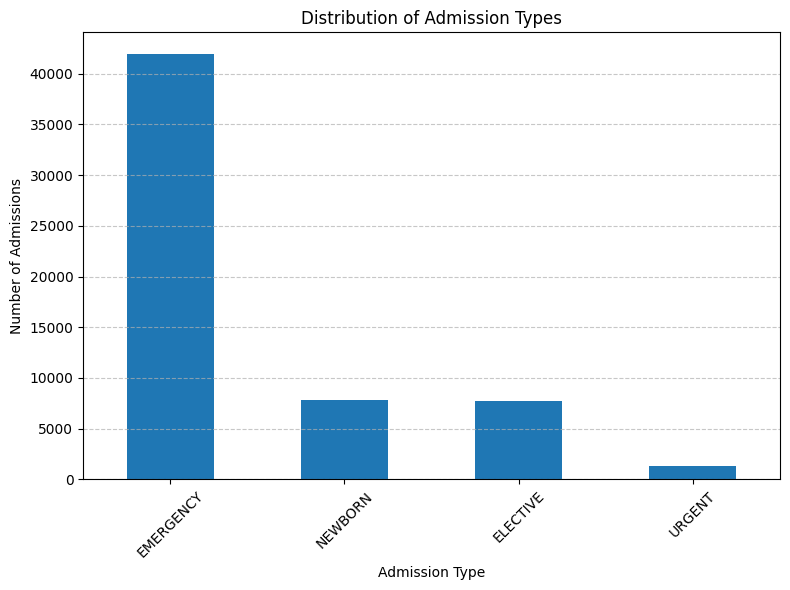

In [7]:
# check out what types of admissions there are
# Count the values
admission_counts = df_admissions['ADMISSION_TYPE'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
admission_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Admission Type')
plt.ylabel('Number of Admissions')
plt.title('Distribution of Admission Types')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [8]:
# clean up diagnosis code table per our lecture series 11
df_diagcode = pd.read_csv('DIAGNOSES_ICD.csv')

# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['ICD9_CODE']
df_diagcode['recode'] = df_diagcode.loc[~df_diagcode['recode'].fillna('').str.contains("[a-zA-Z]"), 'recode']
df_diagcode['recode'] = df_diagcode['recode'].fillna(value='999')
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)
df_diagcode.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,recode
0,1297,109,172335,1.0,40301,403
1,1298,109,172335,2.0,486,486
2,1299,109,172335,3.0,58281,582
3,1300,109,172335,4.0,5855,585
4,1301,109,172335,5.0,4254,425


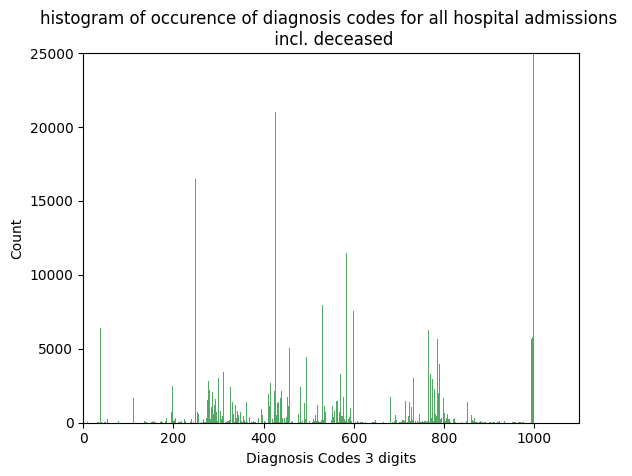

In [9]:
# Plot Occurrence of diagnosis codes Distribution
plt.hist(df_diagcode['recode'], bins=1000, color = '#55a868')
plt.xlim(0, 1100)
plt.ylim(0, 25000)
plt.title('histogram of occurence of diagnosis codes for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Diagnosis Codes 3 digits')
plt.tick_params(top=False, right=False)
plt.show();

In [10]:
# Step 1: Get the top 20 primary_diag codes
top_diags = (
    df_diagcode
    .groupby(['recode'])
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
    .head(20)
)

# Step 2: Print the top 20
print(top_diags)

     recode  count
844     999  98178
325     401  21329
345     427  20998
346     428  20676
205     276  20440
180     250  16454
334     414  15759
201     272  14768
421     518  14608
214     285  12910
477     584  11467
433     530   7965
492     599   7572
478     585   6942
327     403   6440
23       38   6412
635     765   6254
843     998   6204
234     305   6182
650     780   5831


In [11]:
# now we need to process the cci file to mark the diagnoses in df_diagcode as chronic or acute

# Load CCI crosswalk (assumes it has 'icd9_code' and 'chronic_indicator' columns)
df_cci = pd.read_csv('cci2015.csv', skiprows=1)
df_cci.head()

,'ICD-9-CM CODE','ICD-9-CM CODE DESCRIPTION','CATEGORY DESCRIPTION','BODY SYSTEM'
0,'0010 ',CHOLERA D/T VIB CHOLERAE,'0','1'
1,'0011 ',CHOLERA D/T VIB EL TOR,'0','1'
2,'0019 ',CHOLERA NOS,'0','1'
3,'0020 ',TYPHOID FEVER,'0','1'
4,'0021 ',PARATYPHOID FEVER A,'0','1'


In [12]:
# cci has the codes in column '\'ICD-9-CM CODE\''
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_cci['recode'] = df_cci['\'ICD-9-CM CODE\'']
df_cci['recode'] = df_cci.loc[~df_cci['recode'].fillna('').str.contains("[a-zA-Z]"), 'recode']
df_cci['recode'] = df_cci['recode'].fillna(value='999')
df_cci['recode'] = (
    df_cci['recode']
    .astype(str)
    .str.lstrip("'")         # Remove leading single quote
    .str[:3]                 # Keep first 3 characters
    .str.lstrip('0')          # Remove leading zeros (all leading zeros)
)
# Step 4: Make sure empty strings become '999'
df_cci['recode'] = df_cci['recode'].replace('', '999')

# Step 5: Convert to int
df_cci['recode'] = df_cci['recode'].astype(int)

df_cci['chronic'] = (
    df_cci['\'CATEGORY DESCRIPTION\'']
    .fillna('0')             # Fill missing values with '0'
    .astype(str)
    .str.strip()             # Remove leading/trailing whitespace
    .str.strip('"').str.strip("'")  # Remove leading/trailing " and '
    .astype(int)
)

df_cci = pd.concat([
    df_cci,
    pd.get_dummies(df_cci['chronic'], prefix='chronic')
], axis=1)

df_cci.head()


,'ICD-9-CM CODE','ICD-9-CM CODE DESCRIPTION','CATEGORY DESCRIPTION','BODY SYSTEM',recode,chronic,chronic_0,chronic_1
0,'0010 ',CHOLERA D/T VIB CHOLERAE,'0','1',1,0,True,False
1,'0011 ',CHOLERA D/T VIB EL TOR,'0','1',1,0,True,False
2,'0019 ',CHOLERA NOS,'0','1',1,0,True,False
3,'0020 ',TYPHOID FEVER,'0','1',2,0,True,False
4,'0021 ',PARATYPHOID FEVER A,'0','1',2,0,True,False


In [13]:
# now df_cci has multiple entries for our simplified code list, that's too complicated
# Step 1: Select only relevant columns
df_cci_simple = df_cci[['\'ICD-9-CM CODE DESCRIPTION\'', 'recode', 'chronic', 'chronic_0', 'chronic_1']].copy()

# Step 2: Drop duplicates — only keep one row per recode
df_cci_simple = df_cci_simple.drop_duplicates(subset='recode').reset_index(drop=True)
df_cci_simple.rename(columns={'\'ICD-9-CM CODE DESCRIPTION\'': 'primary_diag_desc'}, inplace=True)
df_cci_simple.reset_index(drop=True, inplace=True)

df_cci_simple.head()

,primary_diag_desc,recode,chronic,chronic_0,chronic_1
0,CHOLERA D/T VIB CHOLERAE,1,0,True,False
1,TYPHOID FEVER,2,0,True,False
2,SALMONELLA ENTERITIS,3,0,True,False
3,SHIGELLA DYSENTERIAE,4,0,True,False
4,STAPH FOOD POISONING,5,0,True,False


In [14]:
# let's limit our work to emergency and urgent admissions
df_emergency_urgent = df_admissions[
    df_admissions['ADMISSION_TYPE'].isin(['EMERGENCY', 'URGENT'])
].copy()

df_emergency_urgent.reset_index(drop=True, inplace=True)

# Merge df_emergency_urgent with diagnosis codes and chronic labels
df_adm_diag = pd.merge(
    df_emergency_urgent,
    df_diagcode[['SUBJECT_ID', 'HADM_ID', 'recode']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)

# Merge in the 'chronic' indicator from the simplified CCI table
df_adm_diag = pd.merge(
    df_adm_diag,
    df_cci_simple[['recode', 'chronic', 'primary_diag_desc' ]],
    on='recode',
    how='left'
)

# Separate chronic and acute codes

# Chronic codes
df_chronic = df_adm_diag[df_adm_diag['chronic'] == 1].groupby('HADM_ID')['recode'].apply(list).reset_index()
df_chronic.rename(columns={'recode': 'chronic_codes_list'}, inplace=True)

# Acute codes
df_acute = df_adm_diag[df_adm_diag['chronic'] == 0].groupby('HADM_ID')['recode'].apply(list).reset_index()
df_acute.rename(columns={'recode': 'acute_codes_list'}, inplace=True)

# Merge the lists back into admissions
df_emergency_urgent = df_emergency_urgent.merge(df_chronic, on='HADM_ID', how='left')
df_emergency_urgent = df_emergency_urgent.merge(df_acute, on='HADM_ID', how='left')

# Fill missing lists with empty lists
df_emergency_urgent['chronic_codes_list'] = df_emergency_urgent['chronic_codes_list'].apply(lambda x: x if isinstance(x, list) else [])
df_emergency_urgent['acute_codes_list'] = df_emergency_urgent['acute_codes_list'].apply(lambda x: x if isinstance(x, list) else [])

# Clean chronic and acute code lists: get rid of 999 which is a catch-all, and eliminate duplicates
df_emergency_urgent['chronic_codes_list'] = (
    df_emergency_urgent['chronic_codes_list']
    .apply(lambda x: sorted([code for code in set(x) if code != 999]))
)
df_emergency_urgent['acute_codes_list'] = (
    df_emergency_urgent['acute_codes_list']
    .apply(lambda x: sorted([code for code in set(x) if code != 999]))
)
df_emergency_urgent.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,LOS,DECEASED,chronic_codes_list,acute_codes_list
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,1.144444,0,"[296, 348, 401]","[967, 969]"
1,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,BRAIN MASS,6.768056,0,"[225, 272, 348, 401, 424]",[780]
2,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,2.856944,0,"[250, 410, 414]",[530]
3,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,3.534028,0,"[250, 401, 410, 414]",[]
4,26,197661,2126-05-06 15:16:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,V-TACH,6.988889,0,"[272, 412, 414, 427, 428, 600]","[593, 996]"


Now we need to get the reason for admission, that is our primary diagnosis. We will predict things like LOS and survival per primary diagnosis.

In [15]:
# Select the first ICD-9 code per HADM_ID (our best guess at primary diagnosis)
df_primary_diag = df_diagcode.groupby('HADM_ID')['ICD9_CODE'].first().reset_index()
df_primary_diag.rename(columns={'ICD9_CODE': 'primary_diag'}, inplace=True)

# Merge primary diagnosis code into df_emergency_urgent
df_emergency_urgent = df_emergency_urgent.merge(
    df_primary_diag[['HADM_ID', 'primary_diag']],
    on='HADM_ID',
    how='left'
)

# clean up the primary diagnosis codes like we have done with the other codes
# we could have done this before merge I suppose...
df_emergency_urgent['primary_diag'] = df_emergency_urgent['primary_diag'].fillna('999')
df_emergency_urgent['primary_diag'] = (
    df_emergency_urgent['primary_diag']
    .astype(str)
    .str.strip()
    .str.strip('"').str.strip("'")  # Remove quotes
)
df_emergency_urgent['primary_diag'] = df_emergency_urgent['primary_diag'].where(
    ~df_emergency_urgent['primary_diag'].str.contains('[a-zA-Z]')
)
df_emergency_urgent['primary_diag'] = df_emergency_urgent['primary_diag'].fillna('999')
df_emergency_urgent['primary_diag'] = (
    df_emergency_urgent['primary_diag']
    .str[:3]                # Keep first 3 characters
    .str.lstrip('0')         # Remove leading zeros
)
df_emergency_urgent['primary_diag'] = df_emergency_urgent['primary_diag'].replace('', '999')
df_emergency_urgent['primary_diag'] = df_emergency_urgent['primary_diag'].astype(int)

df_emergency_urgent = df_emergency_urgent.merge(
    df_cci_simple[['recode', 'primary_diag_desc']],  # <-- must include 'recode'
    left_on='primary_diag',
    right_on='recode',
    how='left'
)


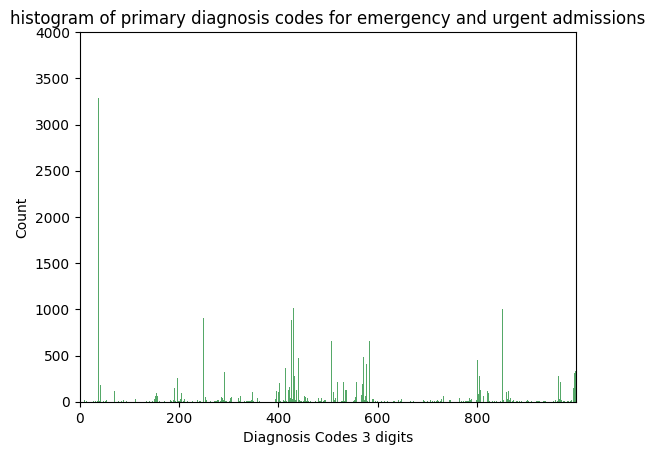

primary_diag
38     3290
410    3240
414    2148
518    1511
428    1425
996    1187
431    1015
852    1003
250     901
427     881
998     712
486     712
434     704
578     669
507     654
584     653
424     521
430     518
571     482
441     478
Name: count, dtype: int64


In [16]:
# so what were the primary diagnosis codes?
# Plot Occurrence of diagnosis codes Distribution
plt.hist(df_emergency_urgent['primary_diag'], bins=1000, color = '#55a868')
plt.xlim(0, 999)
plt.ylim(0, 4000)
plt.title('histogram of primary diagnosis codes for emergency and urgent admissions')
plt.ylabel('Count')
plt.xlabel('Diagnosis Codes 3 digits')
plt.tick_params(top=False, right=False)
plt.show();

# List the top 20 most common primary_diag codes
top_primary_diags = df_emergency_urgent['primary_diag'].value_counts().head(20)

# Display nicely
print(top_primary_diags)


     primary_diag                             primary_diag_desc  count
15             38                      STREPTOCOCCAL SEPTICEMIA   3290
222           410  AMI ANTEROLATERAL WALL (Begin 1980 End 1989)   3240
226           414          CORONARY ATHEROSCLEROSIS  (End 1994)   2148
302           518                            PULMONARY COLLAPSE   1511
238           428                      CONGESTIVE HEART FAILURE   1425
604           996                      MALFUNC CARD DEV/GRF NOS   1187
241           431                      INTRACEREBRAL HEMORRHAGE   1015
508           852                        TRAUM SUBARACHNOID HEM   1003
124           250                      DIABETES UNCOMPL TYPE II    901
237           427                      PAROX ATRIAL TACHYCARDIA    881
281           486                        PNEUMONIA ORGANISM NOS    712
606           998                POSTOPERATIVE SHOCK (end 2011)    712
244           434               CEREBRAL THROMBOSIS  (End 1993)    704
345   

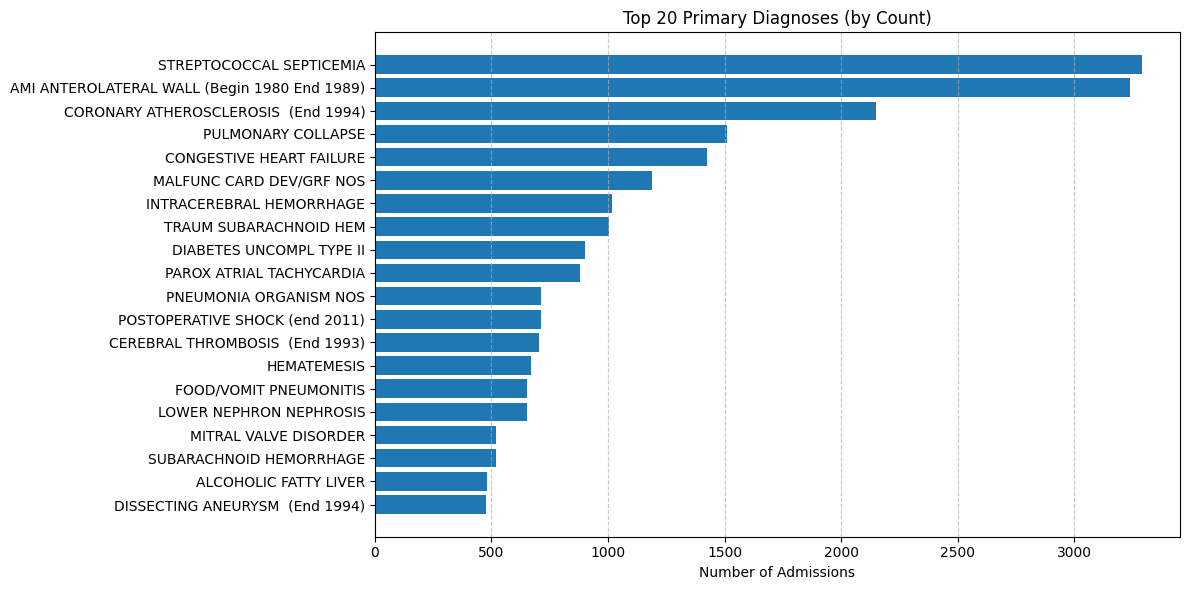

In [20]:
import matplotlib.pyplot as plt

# Step 1: Get the top 20 primary_diag codes
top_primary_diags = (
    df_emergency_urgent
    .groupby(['primary_diag', 'primary_diag_desc'])
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
    .head(20)
)

# Step 2: Print the top 20
print(top_primary_diags)

# Step 3: Plot a bar chart
plt.figure(figsize=(12, 6))
plt.barh(
    top_primary_diags['primary_diag_desc'],
    top_primary_diags['count']
)
plt.xlabel('Number of Admissions')
plt.title('Top 20 Primary Diagnoses (by Count)')
plt.gca().invert_yaxis()  # Highest at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


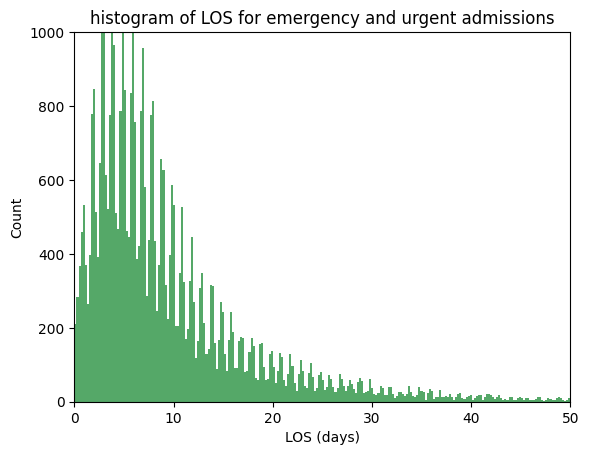

In [21]:
# let's look at the LOS distribution and think about what accuracy we want to get
plt.hist(df_emergency_urgent['LOS'], bins=1000, color = '#55a868')
plt.xlim(0, 50)
plt.ylim(0, 1000)
plt.title('histogram of LOS for emergency and urgent admissions')
plt.ylabel('Count')
plt.xlabel('LOS (days)')
plt.tick_params(top=False, right=False)
plt.show();


In [22]:
df_emergency_urgent = df_emergency_urgent.merge(
    df_patients[['SUBJECT_ID', 'age']],
    on='SUBJECT_ID',
    how='left'
)
print(df_emergency_urgent.columns.tolist())


['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'LOS', 'DECEASED', 'chronic_codes_list', 'acute_codes_list', 'primary_diag', 'recode', 'primary_diag_desc', 'age']


In [23]:
# now eliminate columns we don't want and one hot code ones we need to code

cols = [
    'INSURANCE', 'MARITAL_STATUS',
    'DIAGNOSIS', 'LOS', 'DECEASED', 'chronic_codes_list',
    'acute_codes_list', 'primary_diag', 'age'
]

df_eu_model = df_emergency_urgent[cols].copy()

# One-hot encode the categorical columns
categorical_cols = ['INSURANCE', 'MARITAL_STATUS']
df_eu_model = pd.get_dummies(df_eu_model, columns=categorical_cols)

# Move 'LOS' to the first column for convenience, this is what I want to solve for
# Extract and reorder
los_col = df_eu_model.pop('LOS')
df_eu_model.insert(0, 'LOS', los_col)

df_eu_model.head()

df_eu_model['age'] = df_eu_model['age'].fillna(0)
df_eu_model['chronic_codes_list'] = df_eu_model['chronic_codes_list'].apply(lambda x: x if isinstance(x, list) else [])
df_eu_model['acute_codes_list'] = df_eu_model['acute_codes_list'].apply(lambda x: x if isinstance(x, list) else [])
df_eu_model['DECEASED'] = df_eu_model['DECEASED'].fillna(0)

print(df_eu_model.columns.tolist())

['LOS', 'DIAGNOSIS', 'DECEASED', 'chronic_codes_list', 'acute_codes_list', 'primary_diag', 'age', 'INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay', 'MARITAL_STATUS_DIVORCED', 'MARITAL_STATUS_LIFE PARTNER', 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SEPARATED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_WIDOWED']


What is the data:
table of
patient, admission_id, LOS, deceased, diagnosis codes chronic, diagnosis codes acute, socioeconomic factors [insurance, language, religion, marital_status, ethnicity]

- can I predict LOS (cost? deceased?) for the primary code (the thing that got the patient admitted) as a function of chronic codes and socioeconomic factors
- can I use attention to deal with variable length of chronic codes
- can I make an image of the input data and use CNN
    - there are ~ 1000 ICD9 codes, can binary encode pixels for yes or no
    - also have one hot data for some socioeconomic factors like insurance
    - also have continuous socio data like county income or vote

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
print("PyTorch version:", torch.__version__)
if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0))
    device = torch.device("cuda:0")

# Create two tensors and add them
a = torch.tensor([1.0, 2.0])
b = torch.tensor([3.0, 4.0])
print("Tensor sum:", a + b)

if torch.cuda.is_available():
    a_gpu = a.to("cuda")
    b_gpu = b.to("cuda")
    result = a_gpu + b_gpu
    print("GPU Tensor sum:", result)

PyTorch version: 2.7.0+cu126
CUDA device count: 1
Current device: 0
Device name: NVIDIA RTX A1000 Laptop GPU
Tensor sum: tensor([4., 6.])
GPU Tensor sum: tensor([4., 6.], device='cuda:0')


Now this is the fun part!
We encode our data into images to use a CNN model. If I don't run out of time, can try a transformer that doesn't need fixed input sizes.

In [92]:
import numpy as np
from PIL import Image

# Create a blank image (1000x3), 8-bit grayscale
img_array = np.zeros((1000, 3), dtype=np.uint8)

for i in range(13,15):
    # Example row data (replace with actual values per row in loop)
    chronic_codes_list = df_emergency_urgent.iloc[i]['chronic_codes_list']
    acute_codes_list = df_emergency_urgent.iloc[i]['acute_codes_list']
    age = df_emergency_urgent.iloc[i]['age']

    # Binary indicator columns (from df_eu_model)
    row_data = df_emergency_urgent.iloc[i]

    # ---------------------------------------------
    # Column 0: Chronic codes
    for code in chronic_codes_list:
        if 0 <= code < 1000:
            img_array[code, 0] = 255

    # Column 1: Acute codes
    for code in acute_codes_list:
        if 0 <= code < 1000:
            img_array[code, 1] = 255

    # Column 2, rows 0–99: Age encoding
    age_index = min(max(int(age), 0), 99)
    img_array[age_index, 2] = 255

    # Column 2, rows 100–112: One-hot variables
    encoding_order = [
        'INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare',
        'INSURANCE_Private', 'INSURANCE_Self Pay',
        'MARITAL_STATUS_DIVORCED', 'MARITAL_STATUS_LIFE PARTNER',
        'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SEPARATED',
        'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)',
        'MARITAL_STATUS_WIDOWED'
    ]

    tester2 = row_data.get('INSURANCE_Government', 0)
    for j, key in enumerate(encoding_order):
        if row_data.get(key, 0) == 1:
            img_array[100 + j, 2] = 255

    # Convert to image
    img = Image.fromarray(img_array, mode='L')  # 8-bit grayscale
    img.show()
    filename = str(f'df_eu_model-row-{i}.png')
    img.save(filename)
# end for loop

Below is a pytorch dataloader to create datasets for training and testing from our amazing dataframe.

In [28]:
import numpy as np
import torch
from torch.utils.data import Dataset

class EmergencyAdmissionsDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.encoding_order = [
            'INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare',
            'INSURANCE_Private', 'INSURANCE_Self Pay',
            'MARITAL_STATUS_DIVORCED', 'MARITAL_STATUS_LIFE PARTNER',
            'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SEPARATED',
            'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)',
            'MARITAL_STATUS_WIDOWED'
        ]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Create blank (1000 x 3) 8-bit grayscale image
        img_array = np.zeros((1000, 3), dtype=np.uint8)

        # Chronic codes → column 0
        chronic_codes_list = row['chronic_codes_list'] if isinstance(row['chronic_codes_list'], list) else []
        for code in chronic_codes_list:
            if pd.notna(code) and 0 <= int(code) < 1000:
                img_array[int(code), 0] = 255

        # Acute codes → column 1
        acute_codes_list = row['acute_codes_list'] if isinstance(row['acute_codes_list'], list) else []
        for code in acute_codes_list:
            if pd.notna(code) and 0 <= int(code) < 1000:
                img_array[int(code), 1] = 255

        # Age → column 2, rows 0–99
        if pd.notna(row['age']):
            age_index = min(max(int(row['age']), 0), 99)
            img_array[age_index, 2] = 255

        # Demographics → column 2, rows 100–112
        for i, key in enumerate(self.encoding_order):
            value = row.get(key, 0)
            if pd.notna(value) and value == 1:
                img_array[100 + i, 2] = 255

        # --- Prepare tensor ---
        img_tensor = torch.tensor(img_array, dtype=torch.float32)  # (1000, 3)

        if img_tensor.ndim == 2:
            img_tensor = img_tensor.unsqueeze(0)  # (1, 1000, 3)

        # NOW permute
        img_tensor = img_tensor.permute(2, 1, 0)  # (channels=3, height=1000, width=1)

        img_tensor = img_tensor / 255.0

        # Target can be LOS, DECEASED, or both
        los = torch.tensor(row['LOS'], dtype=torch.float32) if pd.notna(row['LOS']) else torch.tensor(0.0)
        deceased = torch.tensor(row['DECEASED'], dtype=torch.float32) if pd.notna(row['DECEASED']) else torch.tensor(0.0)

        return img_tensor, los, deceased


This just tests the dataset class.
It should return
torch.Size([1, 1000, 3])
1.144444465637207
0.0

In [29]:
dataset = EmergencyAdmissionsDataset(df_eu_model)

# Example
img, los, deceased = dataset[0]
print(img.shape)      # torch.Size([3, 1000, 1])
print(los.item())     # float LOS value
print(deceased.item())  # float 0.0 or 1.0

torch.Size([3, 1000, 1])
1.144444465637207
0.0


This is the CNN we are using. Mostly from the Deep Learning class homework #4 that I finished last week...

In [30]:
class EmergencyMultiTaskCNN(nn.Module):
    def __init__(self):
        super(EmergencyMultiTaskCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, (5,1), stride=(2,1), padding=(2,0))
        self.conv2 = nn.Conv2d(16, 32, (5,1), stride=(2,1), padding=(2,0))
        self.conv3 = nn.Conv2d(32, 64, (5,1), stride=(2,1), padding=(2,0))
        self.conv4 = nn.Conv2d(64, 128, (5,1), stride=(2,1), padding=(2,0))

        self.fc1 = nn.Linear(128 * 63 * 1, 128)

        # Two heads
        self.fc_los = nn.Linear(128, 1)        # Predict LOS (regression)
        self.fc_deceased = nn.Linear(128, 1)   # Predict Deceased (binary)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))

        los = self.fc_los(x)  # Regression output (no activation)
        deceased = torch.sigmoid(self.fc_deceased(x))  # Probability between 0 and 1

        return los.squeeze(1), deceased.squeeze(1)


In [31]:
def validate(model, dataloader, device):
    model.eval()

    total_los_error = 0.0
    total_percent_los_error = 0.0
    total_deceased_correct = 0
    total_samples = 0

    epsilon = 1e-6  # for safe percentage calculation

    with torch.no_grad():
        for imgs, los_targets, deceased_targets in dataloader:
            imgs = imgs.to(device)
            los_targets = los_targets.to(device)
            deceased_targets = deceased_targets.to(device)

            pred_los, pred_deceased = model(imgs)

            # --------------
            # LOS absolute error (for legacy tracking)
            los_error = torch.abs(pred_los - los_targets).sum().item()

            # LOS percentage error
            percent_error = (torch.abs(pred_los - los_targets) / (los_targets + epsilon)) * 100
            percent_error = percent_error.sum().item()

            # --------------
            # Deceased accuracy
            pred_deceased_class = (pred_deceased > 0.5).float()
            deceased_correct = (pred_deceased_class == deceased_targets).sum().item()

            total_los_error += los_error
            total_percent_los_error += percent_error
            total_deceased_correct += deceased_correct
            total_samples += imgs.size(0)

    avg_los_error = total_los_error / total_samples  # Mean Absolute Error (days)
    avg_percent_los_error = total_percent_los_error / total_samples  # Mean Percentage Error (%)
    deceased_accuracy = total_deceased_correct / total_samples  # Accuracy (0-1)

    return avg_los_error, avg_percent_los_error, deceased_accuracy


In [33]:

class LOSPercentErrorLoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(LOSPercentErrorLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, predicted, target):
        abs_error = torch.abs(predicted - target)
        percent_error = abs_error / (target + self.epsilon) * 100
        return percent_error.mean()


In [68]:
from torch import optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os

# Step 1: Stratified split at dataframe level
train_df, val_df = train_test_split(
    df_eu_model,
    test_size=0.2,
    random_state=42,
    stratify=df_eu_model['DECEASED']  # stratify by target label
)

# Step 2: Build datasets separately
train_dataset = EmergencyAdmissionsDataset(train_df)
val_dataset = EmergencyAdmissionsDataset(val_df)

# Step 3: DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
for imgs, los_targets, deceased_targets in train_loader:
    print(imgs.shape)
    break
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = EmergencyMultiTaskCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn_los = LOSPercentErrorLoss()
loss_fn_deceased = nn.BCELoss()

checkpoint_path = 'checkpoint.pth'

if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

    train_losses = checkpoint['train_loss']
    val_los_errors = checkpoint['val_los_error']
    val_los_percent_errors = checkpoint['val_los_percent_error']
    val_deceased_accuracies = checkpoint['val_deceased_accuracy']

    print(f"Resumed from epoch {start_epoch}")
else:
    print(f"No checkpoint found. Starting from scratch.")
    start_epoch = 0

    train_losses = []
    val_los_errors = []
    val_los_percent_errors = []
    val_deceased_accuracies = []

n_epochs = 40
best_val_percent_loss = float('inf')
save_best_only=True
for epoch in range(n_epochs):
    model.train()
    total_loss = 0.0
    total_samples = 0

    for imgs, los_targets, deceased_targets in train_loader:
        imgs = imgs.to(device)
        los_targets = los_targets.to(device)
        deceased_targets = deceased_targets.to(device)

        pred_los, pred_deceased = model(imgs)

        loss_los = loss_fn_los(pred_los, los_targets)
        loss_deceased = loss_fn_deceased(pred_deceased, deceased_targets)

        loss = loss_los / 100.0 + 0.5 * loss_deceased
        #loss = loss_los

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        total_samples += imgs.size(0)

    avg_train_loss = total_loss / total_samples
    train_losses.append(avg_train_loss)

    # Validate
    avg_val_los_error, avg_val_percent_los_error, val_deceased_accuracy = validate(model, val_loader, device)
    val_los_errors.append(avg_val_los_error)
    val_los_percent_errors.append(avg_val_percent_los_error)
    val_deceased_accuracies.append(val_deceased_accuracy)


    print(f"Epoch {epoch+start_epoch+1}/{n_epochs+start_epoch}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val LOS MAE (days): {avg_val_los_error:.4f}")
    print(f"  Val LOS Percent Error (%): {avg_val_percent_los_error:.2f}")
    print(f"  Val Deceased Accuracy: {val_deceased_accuracy:.4f}")

    # Checkpoint logic
    # I got this from Python model on OpenAI, it was useful but save best was most important
    # most of the models got to best pretty fast and then oscillated
    checkpoint = {
    'epoch': epoch+start_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'val_los_error': val_los_errors,
    'val_los_percent_error': val_los_percent_errors,
    'val_deceased_accuracy': val_deceased_accuracies
    }

    if avg_val_percent_los_error < best_val_percent_loss:
        best_val_percent_loss = avg_val_percent_los_error
        torch.save(checkpoint, "best_model_LOS_percent.pth")
        print("  ✅ Saved best model")

    if not save_best_only:
        torch.save(checkpoint, f"epoch_{epoch + start_epoch + 1}.pth")
    # end of training loop

# save last state so we can start again from here
torch.save(checkpoint, 'checkpoint.pth')

torch.Size([32, 3, 1000, 1])
No checkpoint found. Starting from scratch.
Epoch 1/40
  Train Loss: 0.9925
  Val LOS MAE (days): 8.5285
  Val LOS Percent Error (%): 81.94
  Val Deceased Accuracy: 0.8770
  ✅ Saved best model
Epoch 2/40
  Train Loss: 0.8535
  Val LOS MAE (days): 6.3789
  Val LOS Percent Error (%): 80.01
  Val Deceased Accuracy: 0.8786
  ✅ Saved best model
Epoch 3/40
  Train Loss: 0.8308
  Val LOS MAE (days): 6.3522
  Val LOS Percent Error (%): 74.81
  Val Deceased Accuracy: 0.8838
  ✅ Saved best model
Epoch 4/40
  Train Loss: 0.8047
  Val LOS MAE (days): 6.6744
  Val LOS Percent Error (%): 71.01
  Val Deceased Accuracy: 0.8869
  ✅ Saved best model
Epoch 5/40
  Train Loss: 0.7810
  Val LOS MAE (days): 6.1695
  Val LOS Percent Error (%): 71.84
  Val Deceased Accuracy: 0.8875
Epoch 6/40
  Train Loss: 0.7758
  Val LOS MAE (days): 6.6262
  Val LOS Percent Error (%): 71.22
  Val Deceased Accuracy: 0.8856
Epoch 7/40
  Train Loss: 0.7533
  Val LOS MAE (days): 6.7809
  Val LOS Perc

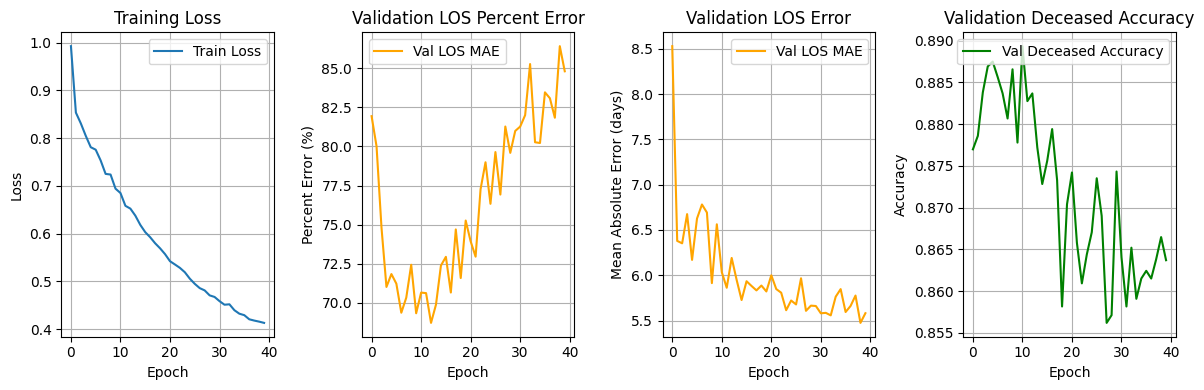

In [69]:
import matplotlib.pyplot as plt

# Plot Training Loss
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# Plot Validation LOS percent Error
plt.subplot(1,4,2)
plt.plot(val_los_percent_errors, label='Val LOS MAE', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Percent Error (%)')
plt.title('Validation LOS Percent Error')
plt.grid(True)
plt.legend()

# Plot Validation LOS Error
plt.subplot(1,4,3)
plt.plot(val_los_errors, label='Val LOS MAE', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (days)')
plt.title('Validation LOS Error')
plt.grid(True)
plt.legend()

# Plot Validation Deceased Accuracy
plt.subplot(1,4,4)
plt.plot(val_deceased_accuracies, label='Val Deceased Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Deceased Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [70]:
import torch

model.eval()

actual_los_list = []
predicted_los_list = []

with torch.no_grad():
    for imgs, los_targets, deceased_targets in val_loader:
        imgs = imgs.to(device)
        los_targets = los_targets.to(device)

        pred_los, _ = model(imgs)

        actual_los_list.extend(los_targets.cpu().numpy())
        predicted_los_list.extend(pred_los.cpu().numpy())


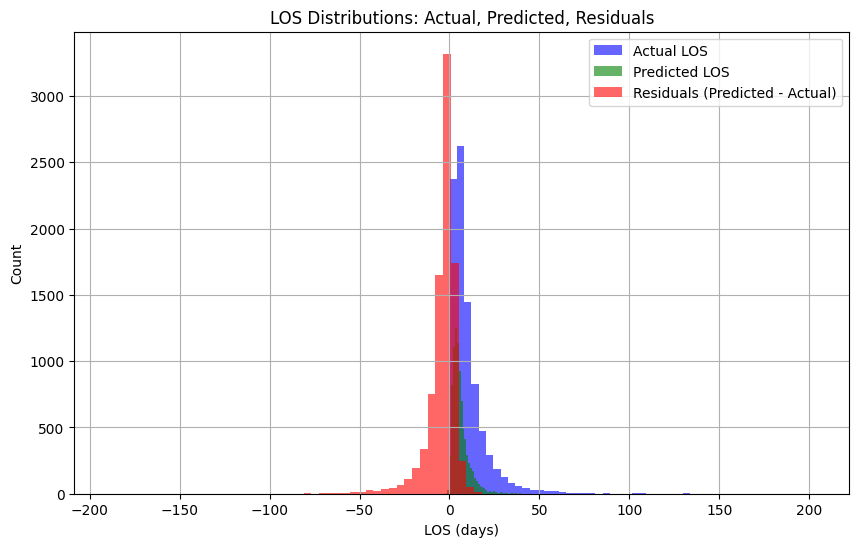

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have:
# - actual_los_list
# - predicted_los_list

actual_los_array = np.array(actual_los_list)
predicted_los_array = np.array(predicted_los_list)
residuals = predicted_los_array - actual_los_array  # (prediction - ground truth)

plt.figure(figsize=(10, 6))

# Plot all three histograms on the same figure
plt.hist(actual_los_array, bins=50, alpha=0.6, label='Actual LOS', color='blue')
plt.hist(predicted_los_array, bins=50, alpha=0.6, label='Predicted LOS', color='green')
plt.hist(residuals, bins=50, alpha=0.6, label='Residuals (Predicted - Actual)', color='red')

plt.xlabel('LOS (days)')
plt.ylabel('Count')
plt.title('LOS Distributions: Actual, Predicted, Residuals')
plt.legend()
plt.grid(True)
plt.show()


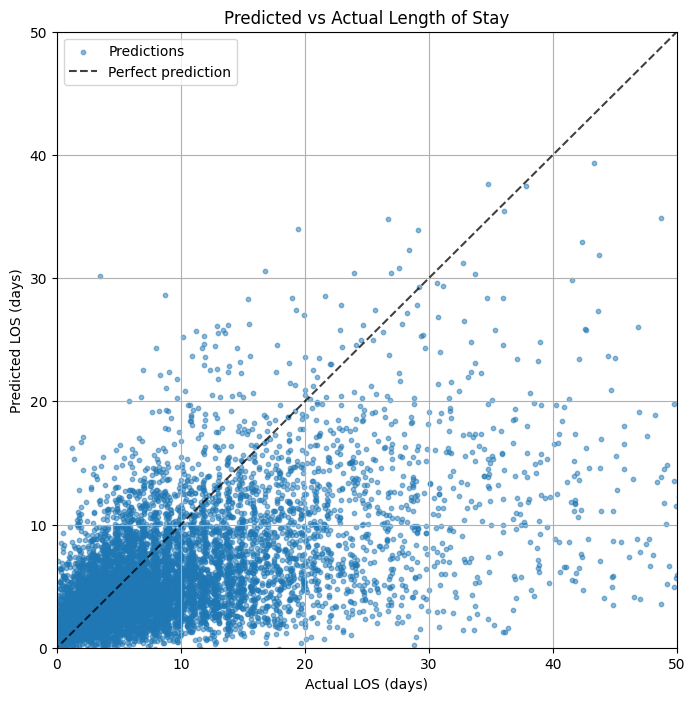

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have:
# - actual_los_list
# - predicted_los_list

actual_los_array = np.array(actual_los_list)
predicted_los_array = np.array(predicted_los_list)

plt.figure(figsize=(8, 8))

# Scatter plot
plt.scatter(actual_los_array, predicted_los_array, alpha=0.5, s=10, label='Predictions')

# Add y = x line (perfect predictions)
lims = [
    np.min([actual_los_array.min(), predicted_los_array.min()]),
    np.max([actual_los_array.max(), predicted_los_array.max()]),
]
plt.plot(lims, lims, 'k--', alpha=0.75, label='Perfect prediction')

plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel('Actual LOS (days)')
plt.ylabel('Predicted LOS (days)')
plt.title('Predicted vs Actual Length of Stay')
plt.legend()
plt.grid(True)
plt.show()


Confusion Matrix:
[[7007  554]
 [ 627  477]]


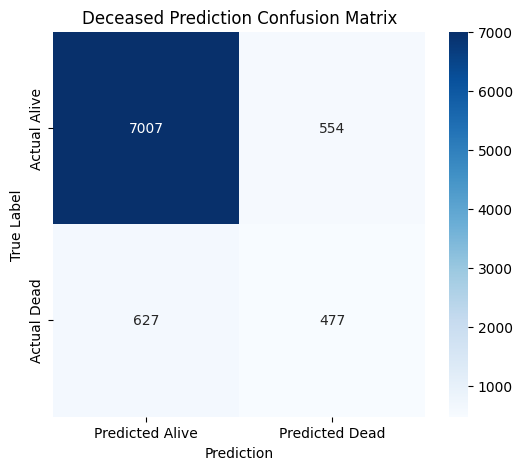

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
model.eval()

actual_deceased_list = []
predicted_deceased_list = []

with torch.no_grad():
    for imgs, los_targets, deceased_targets in val_loader:
        imgs = imgs.to(device)
        deceased_targets = deceased_targets.to(device)

        _, pred_deceased = model(imgs)

        pred_deceased_class = (pred_deceased > 0.5).float()

        actual_deceased_list.extend(deceased_targets.cpu().numpy())
        predicted_deceased_list.extend(pred_deceased_class.cpu().numpy())

conf_mat = confusion_matrix(actual_deceased_list, predicted_deceased_list)

print("Confusion Matrix:")
print(conf_mat)

plt.figure(figsize=(6, 5))

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Alive', 'Predicted Dead'],
            yticklabels=['Actual Alive', 'Actual Dead'])

plt.xlabel('Prediction')
plt.ylabel('True Label')
plt.title('Deceased Prediction Confusion Matrix')
plt.show()

In [76]:
# OK those results are not too good. Let's limit the primary diagnoses so we are not trying to model many very different patient progressions.

# top 20 most common 'primary_diag' codes
top20_primary_diag = (
    df_emergency_urgent['primary_diag']
    .value_counts()
    .head(20)
    .index.tolist()
)

df_eu_top20 = df_emergency_urgent[
    df_emergency_urgent['primary_diag'].isin(top20_primary_diag)
    ].copy()

# reset index for the new dataframe
df_eu_top20.reset_index(drop=True, inplace=True)

print(f"Created df_eu_top20 with {len(df_eu_top20)} rows.")


Created df_eu_top20 with 22704 rows.


Now we will repeat our model training exercise. We were so smart when we made it, all I have to do is to replace the dataset.


In [56]:
# testing
dataset = EmergencyAdmissionsDataset(df_eu_top20)

# Example
img, los, deceased = dataset[0]
print(img.shape)      # torch.Size([3, 1000, 1])
print(los.item())     # float LOS value
print(deceased.item())

torch.Size([3, 1000, 1])
2.8569445610046387
0.0


You know what, I'm going to repeat the training loop and rename a few things. Could put this in a function with parameters.

In [77]:
from torch import optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os

# Step 1: Stratified split at dataframe level
train_df, val_df = train_test_split(
    df_eu_top20,
    test_size=0.2,
    random_state=42,
    stratify=df_eu_top20['DECEASED']  # stratify by target label
)

# Step 2: Build datasets separately
train_dataset = EmergencyAdmissionsDataset(train_df)
val_dataset = EmergencyAdmissionsDataset(val_df)

# Step 3: DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
for imgs, los_targets, deceased_targets in train_loader:
    print(imgs.shape)
    break
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = EmergencyMultiTaskCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn_los = LOSPercentErrorLoss()
loss_fn_deceased = nn.BCELoss()

checkpoint_path = 'checkpoint_top20.pth'

if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

    train_losses = checkpoint['train_loss']
    val_los_errors = checkpoint['val_los_error']
    val_los_percent_errors = checkpoint['val_los_percent_error']
    val_deceased_accuracies = checkpoint['val_deceased_accuracy']

    print(f"Resumed from epoch {start_epoch}")
else:
    print(f"No checkpoint found. Starting from scratch.")
    start_epoch = 0

    train_losses = []
    val_los_errors = []
    val_los_percent_errors = []
    val_deceased_accuracies = []

n_epochs = 40
best_val_percent_loss = float('inf')
save_best_only=True
for epoch in range(n_epochs):
    model.train()
    total_loss = 0.0
    total_samples = 0

    for imgs, los_targets, deceased_targets in train_loader:
        imgs = imgs.to(device)
        los_targets = los_targets.to(device)
        deceased_targets = deceased_targets.to(device)

        pred_los, pred_deceased = model(imgs)

        loss_los = loss_fn_los(pred_los, los_targets)
        loss_deceased = loss_fn_deceased(pred_deceased, deceased_targets)

        loss = loss_los / 100.0 + 0.5 * loss_deceased
        # loss = loss_los

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        total_samples += imgs.size(0)

    avg_train_loss = total_loss / total_samples
    train_losses.append(avg_train_loss)

    # Validate
    avg_val_los_error, avg_val_percent_los_error, val_deceased_accuracy = validate(model, val_loader, device)
    val_los_errors.append(avg_val_los_error)
    val_los_percent_errors.append(avg_val_percent_los_error)
    val_deceased_accuracies.append(val_deceased_accuracy)


    print(f"Epoch {epoch+start_epoch+1}/{n_epochs+start_epoch}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val LOS MAE (days): {avg_val_los_error:.4f}")
    print(f"  Val LOS Percent Error (%): {avg_val_percent_los_error:.2f}")
    print(f"  Val Deceased Accuracy: {val_deceased_accuracy:.4f}")

    # Checkpoint logic
    # I got this from Python model on OpenAI, it was useful but save best was most important
    # most of the models got to best pretty fast and then oscillated
    checkpoint = {
    'epoch': epoch+start_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'val_los_error': val_los_errors,
    'val_los_percent_error': val_los_percent_errors,
    'val_deceased_accuracy': val_deceased_accuracies
    }

    if avg_val_percent_los_error < best_val_percent_loss:
        best_val_percent_loss = avg_val_percent_los_error
        torch.save(checkpoint, "best_model_LOS_percent_top20.pth")
        print("  ✅ Saved best model")

    if not save_best_only:
        torch.save(checkpoint, f"epoch_{epoch + start_epoch + 1}_top20.pth")
    # end of training loop

# save last state so we can start again from here
torch.save(checkpoint, 'checkpoint_top20.pth')

torch.Size([32, 3, 1000, 1])
No checkpoint found. Starting from scratch.
Epoch 1/40
  Train Loss: 1.0311
  Val LOS MAE (days): 8.4341
  Val LOS Percent Error (%): 87.97
  Val Deceased Accuracy: 0.8551
  ✅ Saved best model
Epoch 2/40
  Train Loss: 0.9002
  Val LOS MAE (days): 7.0781
  Val LOS Percent Error (%): 78.54
  Val Deceased Accuracy: 0.8573
  ✅ Saved best model
Epoch 3/40
  Train Loss: 0.8426
  Val LOS MAE (days): 6.9735
  Val LOS Percent Error (%): 77.76
  Val Deceased Accuracy: 0.8624
  ✅ Saved best model
Epoch 4/40
  Train Loss: 0.8234
  Val LOS MAE (days): 6.3791
  Val LOS Percent Error (%): 88.35
  Val Deceased Accuracy: 0.8683
Epoch 5/40
  Train Loss: 0.7962
  Val LOS MAE (days): 6.6234
  Val LOS Percent Error (%): 79.39
  Val Deceased Accuracy: 0.8654
Epoch 6/40
  Train Loss: 0.7659
  Val LOS MAE (days): 6.4536
  Val LOS Percent Error (%): 78.38
  Val Deceased Accuracy: 0.8540
Epoch 7/40
  Train Loss: 0.7571
  Val LOS MAE (days): 6.4975
  Val LOS Percent Error (%): 79.84


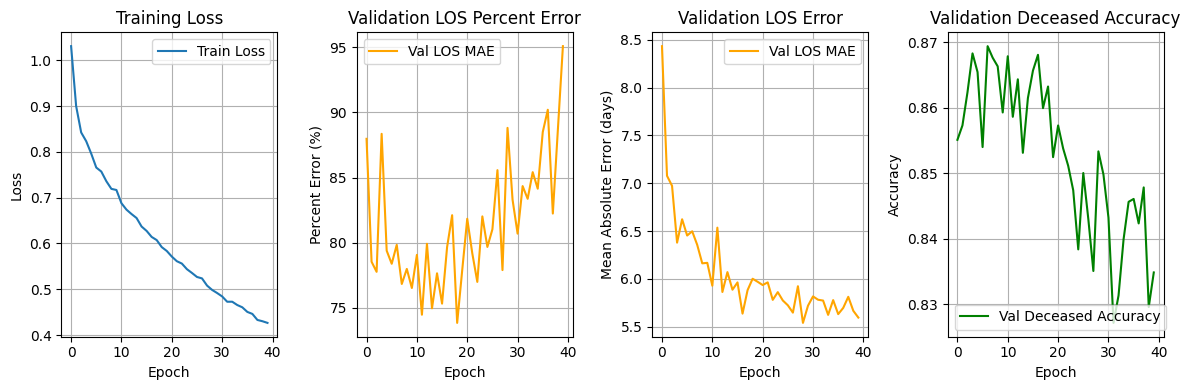

In [79]:
import matplotlib.pyplot as plt

# Plot Training Loss
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# Plot Validation LOS percent Error
plt.subplot(1,4,2)
plt.plot(val_los_percent_errors, label='Val LOS MAE', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Percent Error (%)')
plt.title('Validation LOS Percent Error')
plt.grid(True)
plt.legend()

# Plot Validation LOS Error
plt.subplot(1,4,3)
plt.plot(val_los_errors, label='Val LOS MAE', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (days)')
plt.title('Validation LOS Error')
plt.grid(True)
plt.legend()

# Plot Validation Deceased Accuracy
plt.subplot(1,4,4)
plt.plot(val_deceased_accuracies, label='Val Deceased Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Deceased Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


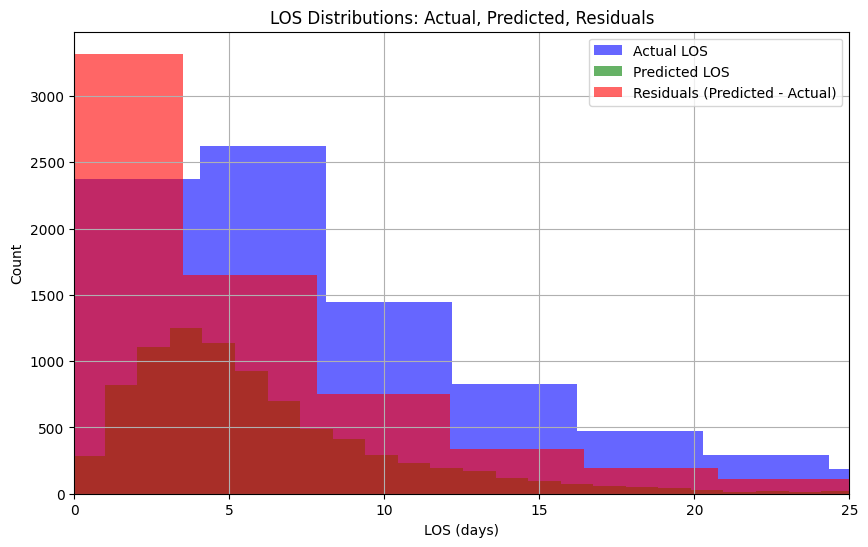

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have:
# - actual_los_list
# - predicted_los_list

actual_los_array = np.array(actual_los_list)
predicted_los_array = np.array(predicted_los_list)
residuals = actual_los_array - predicted_los_array   # (prediction - ground truth)

plt.figure(figsize=(10, 6))

# Plot all three histograms on the same figure
plt.hist(actual_los_array, bins=50, alpha=0.6, label='Actual LOS', color='blue')
plt.hist(predicted_los_array, bins=50, alpha=0.6, label='Predicted LOS', color='green')
plt.hist(residuals, bins=50, alpha=0.6, label='Residuals (Predicted - Actual)', color='red')

plt.xlabel('LOS (days)')
plt.xlim(0, 25)
plt.ylabel('Count')
plt.title('LOS Distributions: Actual, Predicted, Residuals')
plt.legend()
plt.grid(True)
plt.show()


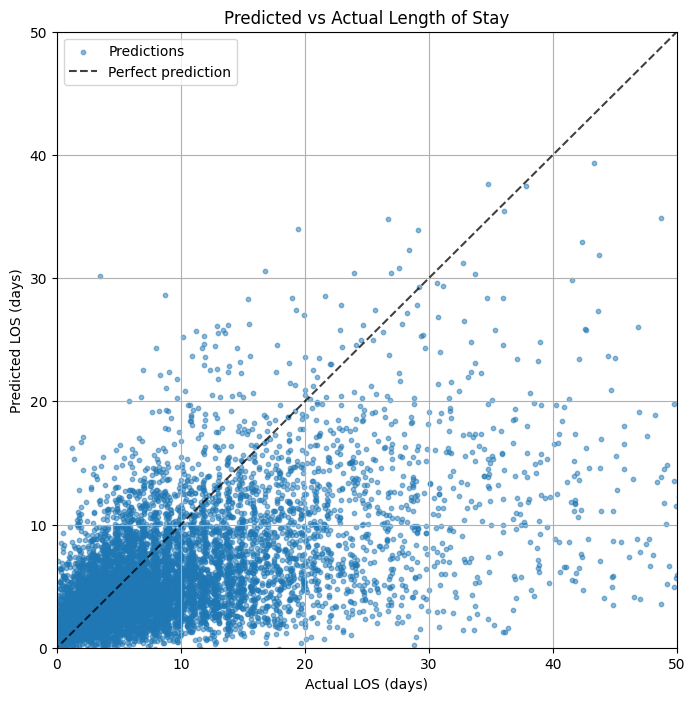

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have:
# - actual_los_list
# - predicted_los_list

actual_los_array = np.array(actual_los_list)
predicted_los_array = np.array(predicted_los_list)

plt.figure(figsize=(8, 8))

# Scatter plot
plt.scatter(actual_los_array, predicted_los_array, alpha=0.5, s=10, label='Predictions')

# Add y = x line (perfect predictions)
lims = [
    np.min([actual_los_array.min(), predicted_los_array.min()]),
    np.max([actual_los_array.max(), predicted_los_array.max()]),
]
plt.plot(lims, lims, 'k--', alpha=0.75, label='Perfect prediction')

plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel('Actual LOS (days)')
plt.ylabel('Predicted LOS (days)')
plt.title('Predicted vs Actual Length of Stay')
plt.legend()
plt.grid(True)
plt.show()
